In [3]:
#Libraries
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA

import pandas as pd
import glob
import os
import re
import pickle



In [22]:
# get the most recent data of the current season, as the csv cannot be used as a whole (all season's games for each team
# except the last 5:

current_season_df = pd.read_csv('../data/current_season/buli_24_25.csv')

# take out the past 5 matches per team, so the last 45 games:
current_season_beginning = current_season_df.iloc[:-45]
current_season_beginning.to_csv('../data/buli_24_25_exc_last_5.csv')

In [24]:
# Specify the folder path where CSV files are stored
folder_path = '../data/'

# Use glob to find all CSV files in the specified folder
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Use a list comprehension to read each CSV file into a DataFrame and ensure 'Date' is string
df_list = []
for file in all_files:
    try:
        # Read each CSV and convert 'Date' to string format
        buli_df = pd.read_csv(file, encoding='ISO-8859-1', dtype={'Date': str})
        df_list.append(buli_df)
    except pd.errors.ParserError as e:
        print(f"ParserError parsing {file}: {e}")
    except UnicodeDecodeError as e:
        print(f"UnicodeDecodeError in {file}: {e}")

# Concatenate all DataFrames in the list into a single DataFrame
buli_df = pd.concat(df_list, ignore_index=True)

# Standardize and parse the 'Date' column
buli_df['Date'] = buli_df['Date'].str.strip()  # Remove extra whitespace
buli_df['Date'] = buli_df['Date'].replace(r'[/-]', '-', regex=True)  # Replace separators with '-'

# Attempt to parse dates as `dayfirst` and handle both `dd/mm/yyyy` and `dd/mm/yy`
buli_df['Date'] = buli_df['Date'].apply(lambda x: re.sub(r'(\d{2}/\d{2}/)(\d{2})$', r'\120\2', x))
buli_df['Date'] = pd.to_datetime(buli_df['Date'], dayfirst=True, errors='coerce')

# Check for any remaining NaT values in 'Date' after parsing
missing_dates = buli_df[buli_df['Date'].isna()]
if not missing_dates.empty:
    print("Warning: Some dates could not be parsed after concatenation.")
    print(missing_dates)

# Sort by date
buli_df = buli_df.sort_values(['Date']).reset_index(drop=True)

# Display the combined DataFrame
print("Final combined DataFrame with parsed dates:")
buli_df

Final combined DataFrame with parsed dates:


/var/folders/72/b7zxktp96cz1n4tjk3mlbj5w0000gn/T/ipykernel_7530/3583668836.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  buli_df['Date'] = pd.to_datetime(buli_df['Date'], dayfirst=True, errors='coerce')


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,SJH,SJD,SJA
0,D1,2014-08-22,Bayern Munich,Wolfsburg,2,1,H,1,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.25,5.8,9.00
1,D1,2014-08-23,Hoffenheim,Augsburg,2,0,H,2,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.91,3.4,3.75
2,D1,2014-08-23,Hertha,Werder Bremen,2,2,D,1,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.95,3.4,3.75
3,D1,2014-08-23,Dortmund,Leverkusen,0,2,A,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.57,4.0,5.25
4,D1,2014-08-23,FC Koln,Hamburg,0,0,D,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.95,3.4,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,D1,2024-10-05,St Pauli,Mainz,0,3,A,0,2,A,...,2.24,3.45,3.70,2.06,1.93,1.93,2.04,NaN,NaN,NaN
3110,D1,2024-10-05,Bochum,Wolfsburg,1,3,A,0,2,A,...,3.20,3.80,2.32,1.66,2.48,1.96,2.02,NaN,NaN,NaN
3111,D1,2024-10-06,Heidenheim,RB Leipzig,0,1,A,0,0,D,...,5.30,4.10,1.74,1.69,2.42,2.05,1.94,NaN,NaN,NaN
3112,D1,2024-10-06,Ein Frankfurt,Bayern Munich,3,3,D,2,2,D,...,6.20,4.90,1.57,1.44,3.25,2.10,1.89,NaN,NaN,NaN


In [26]:
#checking for null values
buli_df.isna().sum()
#dropping rows & columns with all null values
buli_df.dropna(axis=1, how='all', inplace=True) #dropped 3 columns
buli_df.dropna(axis=0, how='all',inplace=True) #0 rows dropped

In [28]:
# Calculating the npm (number of past matches) stats for feature selection. Best results with npm = 5

import pandas as pd

buli_df_red = buli_df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']]

df = buli_df_red

# Define stats dictionary with the specified columns
stats = {
    'goals': {'scored': ('FTHG', 'FTAG'), 'conceded': ('FTAG', 'FTHG')},
    'shots': {'taken': ('HS', 'AS'), 'conceded': ('AS', 'HS')},
    'shots_on_target': {'taken': ('HST', 'AST'), 'conceded': ('AST', 'HST')},
    'fouls': {'fouls': ('HF', 'AF'), 'fouled': ('AF', 'HF')},
    'corners': {'taken': ('HC', 'AC'), 'conceded': ('AC', 'HC')},
    'yellow_cards': {'received': ('HY', 'AY'), 'provoked': ('AY', 'HY')},
    'red_cards': {'received': ('HR', 'AR'), 'provoked': ('AR', 'HR')},
}

# Define `npm` for the number of past matches to consider
npm = 5

# Initialize an empty list to accumulate each row's data as a dictionary
rows_list = []

# Iterate through each row to calculate rolling stats based on home and away perspectives
for index, row in df.iterrows():
    team_h = row['HomeTeam']
    team_a = row['AwayTeam']
    date = row['Date']
    
    # Get the past `npm` games for the home team, filtered by games before the current match date
    past_matches_home = df[((df['HomeTeam'] == team_h) | (df['AwayTeam'] == team_h)) & (df['Date'] < date)]
    past_matches_home = past_matches_home.tail(npm)

    # Get the past `npm` games for the away team, filtered by games before the current match date
    past_matches_away = df[((df['HomeTeam'] == team_a) | (df['AwayTeam'] == team_a)) & (df['Date'] < date)]
    past_matches_away = past_matches_away.tail(npm)

    # Initialize a dictionary to store the calculated stats for each row
    row_stats = {
        'Date': date,
        'HomeTeam': team_h,
        'AwayTeam': team_a,
        'FTR': row['FTR'],
        'FTHG': row['FTHG'],
        'FTAG': row['FTAG'],
    }
    
    # Calculate stats for the home team based on whether they played home or away in past matches
    for stat, subcategories in stats.items():
        for subcategory, columns in subcategories.items():
            home_column, away_column = columns
            # Sum the stat when the home team was actually playing at home
            stat_home_as_home = past_matches_home.loc[past_matches_home['HomeTeam'] == team_h, home_column].sum()
            # Sum the stat when the home team was actually playing as the away team
            stat_home_as_away = past_matches_home.loc[past_matches_home['AwayTeam'] == team_h, away_column].sum()
            row_stats[f'p_home_{stat}_{subcategory}'] = stat_home_as_home + stat_home_as_away
            
    # Calculate stats for the away team based on whether they played home or away in past matches
    for stat, subcategories in stats.items():
        for subcategory, columns in subcategories.items():
            home_column, away_column = columns
            # Sum the stat when the away team was actually playing at home
            stat_away_as_home = past_matches_away.loc[past_matches_away['HomeTeam'] == team_a, home_column].sum()
            # Sum the stat when the away team was actually playing as the away team
            stat_away_as_away = past_matches_away.loc[past_matches_away['AwayTeam'] == team_a, away_column].sum()
            row_stats[f'p_away_{stat}_{subcategory}'] = stat_away_as_home + stat_away_as_away

    # Calculate points for the home team in the past `npm` games
    points_home = (
        (past_matches_home.loc[past_matches_home['HomeTeam'] == team_h, 'FTR'] == 'H').sum() * 3 +
        (past_matches_home.loc[past_matches_home['AwayTeam'] == team_h, 'FTR'] == 'A').sum() * 3 +
        (past_matches_home['FTR'] == 'D').sum() * 1
    )
    row_stats[f'p_home_points'] = points_home
    
    # Calculate points for the away team in the past `npm` games
    points_away = (
        (past_matches_away.loc[past_matches_away['HomeTeam'] == team_a, 'FTR'] == 'H').sum() * 3 +
        (past_matches_away.loc[past_matches_away['AwayTeam'] == team_a, 'FTR'] == 'A').sum() * 3 +
        (past_matches_away['FTR'] == 'D').sum() * 1
    )
    row_stats[f'p_away_points'] = points_away
    
    # Append the dictionary for this row to the list
    rows_list.append(row_stats)

# Convert the list of dictionaries to a DataFrame
rolling_stats = pd.DataFrame(rows_list)

# Display the final DataFrame with only the desired columns
rolling_stats

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,p_home_goals_scored,p_home_goals_conceded,p_home_shots_taken,p_home_shots_conceded,...,p_away_fouls_fouls,p_away_fouls_fouled,p_away_corners_taken,p_away_corners_conceded,p_away_yellow_cards_received,p_away_yellow_cards_provoked,p_away_red_cards_received,p_away_red_cards_provoked,p_home_points,p_away_points
0,2014-08-22,Bayern Munich,Wolfsburg,H,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-23,Hoffenheim,Augsburg,H,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-23,Hertha,Werder Bremen,D,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-23,Dortmund,Leverkusen,A,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-23,FC Koln,Hamburg,D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,2024-10-05,St Pauli,Mainz,A,0,3,4,6,56,50,...,55,45,28,44,15,15,2,3,4,5
3110,2024-10-05,Bochum,Wolfsburg,A,1,3,5,11,63,90,...,68,62,16,21,20,15,1,1,1,4
3111,2024-10-06,Heidenheim,RB Leipzig,A,0,1,10,7,55,60,...,44,62,26,34,6,13,1,0,9,11
3112,2024-10-06,Ein Frankfurt,Bayern Munich,D,3,3,11,6,71,76,...,59,56,29,9,9,5,0,0,12,13


In [30]:
# Labelling of the categorical target variable Fulltime Result (FTR)
rolling_stats["FTR_num"] = rolling_stats["FTR"].apply(lambda x: 1 if x == "D" else (2 if x == "H" else 3))

In [44]:
## Set up logistic regression model including PCA


# Select features and target
features_cl = rolling_stats.select_dtypes("number").drop(columns=["FTHG", "FTAG", "FTR_num"])
target_cl = rolling_stats["FTR_num"]

# Split data into training and test sets
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(features_cl, target_cl)

# Scaling
scaler = MinMaxScaler()
scaler.fit(X_train_cl)
X_train_cl_scaled = scaler.transform(X_train_cl)
X_test_cl_scaled = scaler.transform(X_test_cl)

# Dimensionality Reduction with PCA
pca = PCA(n_components=22)  # Set n_components to a suitable number (adjust as needed)
X_train_cl_pca = pca.fit_transform(X_train_cl_scaled)
X_test_cl_pca = pca.transform(X_test_cl_scaled)

# Logistic regression on PCA-transformed data
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
log_reg.fit(X_train_cl_pca, y_train_cl)

# Make predictions on the test set
y_pred = log_reg.predict(X_test_cl_pca)

# Evaluate the model
accuracy = accuracy_score(y_test_cl, y_pred)
print(f"Accuracy: {accuracy}")

# Displaying classification report and confusion matrix for deeper insights
print("\nClassification Report:")
print(classification_report(y_test_cl, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cl, y_pred))

# Save the scaler and PCA to transform new data in Streamlit
import pickle

with open("../pickle_files/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("../pickle_files/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

# Save the logistic regression model for Streamlit
with open('../pickle_files/log_reg_model.pkl', 'wb') as file:
    pickle.dump(log_reg, file)

Accuracy: 0.5263157894736842

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.01      0.01       183
           2       0.53      0.82      0.64       357
           3       0.52      0.49      0.50       239

    accuracy                           0.53       779
   macro avg       0.52      0.44      0.39       779
weighted avg       0.52      0.53      0.45       779


Confusion Matrix:
[[  1 138  44]
 [  0 293  64]
 [  1 122 116]]


In [40]:
# Save the scaler and PCA to transform new data in Streamlit
import pickle

with open("../pickle_files/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("../pickle_files/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

# Save the logistic regression model for Streamlit
with open('../pickle_files/log_reg_model.pkl', 'wb') as file:
    pickle.dump(log_reg, file)

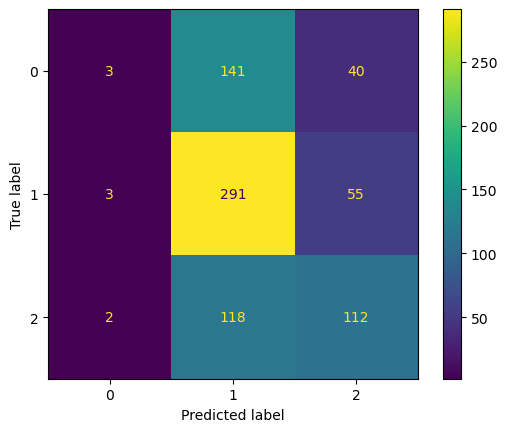

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_cl, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig("confusion_matrix.png", format="png", dpi=300)
plt.show()